In [1]:
import json
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import hazm
from tqdm import tqdm
import torch
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

# Check GPU Availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Text normalization function

In [3]:
normalizer = hazm.Normalizer()
def text_normalization(text):
    text = normalizer.normalize(text)

    return text

# Model and Tokenizer

In [4]:
# Path to the directory where the model was saved
model_path = "fine_tuned_fabert"

# Load the trained model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load the tokenizer (optional but recommended)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [5]:
def print_model_parameters(model):
    # Total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    # Trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

# Example usage
print_model_parameters(model)

Total parameters: 124,442,882
Trainable parameters: 124,442,882


# Single Inference

In [6]:
# Input text
input_text = "علی به مدرسه رفت"
input_text = text_normalization(input_text)
input_text

'علی به مدرسه رفت'

In [7]:
# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Move the model and input to GPU if available
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

In [8]:
# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get the predicted label
predicted_label = logits.argmax(dim=1).item()
print(f"Predicted Label: {predicted_label}")

Predicted Label: 1


# Data Preparation

In [9]:
# Load JSON data
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

In [10]:
base_path = "/media/amin/T7 SHIELD/Projects/Persian-Informal-Formal/Datasets/ParsMap"

train_data = load_data(f"{base_path}/ParsMap-train.json")
val_data   = load_data(f"{base_path}/ParsMap-val.json")
test_data  = load_data(f"{base_path}/ParsMap-test.json")

In [11]:
print(f'#of training samples: {len(train_data.items())}')
print('\n')
print(f'#of validation samples: {len(val_data.items())}')
print('\n')
print(f'#of testing samples: {len(test_data.items())}')
print('\n')

#of training samples: 35009


#of validation samples: 7502


#of testing samples: 7503




In [12]:
# Convert data into lists for binary classification
def prepare_data(data):
    inputs, labels = [], []
    for _, value in tqdm(data.items()):
        try:
            informal_text = value['inFormalForm']
            informal_text = text_normalization(informal_text)
            inputs.append(informal_text)
            labels.append(0)  # Add 0 for inFormalForm
        except Exception as e:
            print(f"An error occurred: {e}")


        try:
            formal_text  = value['formalForm']
            formal_text = text_normalization(formal_text)
            inputs.append(formal_text)
            labels.append(1)  # Add 1 for formalForm
        except Exception as e:
            print(f"An error occurred: {e}")

    return inputs, labels

In [13]:
train_texts, train_labels = prepare_data(train_data)
val_texts,   val_labels   = prepare_data(val_data)
test_texts,  test_labels  = prepare_data(test_data)

 45%|████▌     | 15825/35009 [00:02<00:03, 6126.85it/s]

An error occurred: 'float' object has no attribute 'translate'


100%|██████████| 7503/7503 [00:01<00:00, 6107.75it/s]


In [14]:
# Tokenize the data

def tokenize_data(texts, labels):
    tokenized = tokenizer(
        texts, padding=True, truncation=True, max_length=512, return_tensors="pt"
    )
    tokenized["labels"] = torch.tensor(labels)
    return tokenized

In [15]:
train_encodings = tokenize_data(train_texts, train_labels)
val_encodings   = tokenize_data(val_texts, val_labels)
test_encodings  = tokenize_data(test_texts, test_labels)

In [16]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

# Prepare the Dataset

In [17]:
class TextDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

In [18]:
train_dataset = TextDataset(train_encodings)
val_dataset   = TextDataset(val_encodings)
test_dataset  = TextDataset(test_encodings)

# Model Evaluation

In [19]:
val_loader  = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [20]:
def evaluate_model_with_argmax_probs(model, test_loader, device="cpu"):
    """
    Evaluate a trained model on a test dataset and compute predictions, true labels, 
    and the probabilities of the most likely class (argmax).

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (str): The device to perform evaluation on, either "cpu" or "cuda" (default: "cpu").

    Returns:
        tuple: A tuple containing:
            - true_labels (np.ndarray): Ground truth labels from the test dataset.
            - predictions (np.ndarray): Predicted labels for the test dataset.
            - argmax_probs (np.ndarray): Probabilities of the most likely class (argmax) for each prediction.

    Example:
        true_labels, predictions, argmax_probs = evaluate_model_with_argmax_probs(
            model, test_loader, device="cuda"
        )

    Notes:
        - Ensure the model and test data are compatible with the evaluation setup.
        - The function uses softmax to compute probabilities and extracts the probabilities 
          corresponding to the predicted class (argmax).
    """
    model.eval()
    predictions, true_labels, argmax_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move batch to the specified device
            batch = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            # Compute probabilities using softmax
            probs = softmax(logits, dim=-1)

            # Collect predictions, true labels, and argmax probabilities
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())
            argmax_probs.extend(probs.gather(1, preds.unsqueeze(1)).squeeze(1).cpu().numpy())

    # Convert to NumPy arrays for analysis
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    argmax_probs = np.array(argmax_probs)

    # Return results
    return  true_labels, predictions, argmax_probs

In [21]:
def compute_metrics(predictions, true_labels):
    """
    Compute the number of equal/unequal predictions and accuracy.

    Args:
        predictions (np.ndarray): Predicted labels.
        true_labels (np.ndarray): Ground truth labels.

    Returns:
        tuple: 
            - equal_count (int): Number of correct predictions.
            - unequal_count (int): Number of incorrect predictions.
            - accuracy (float): Accuracy of the predictions.
    """
    equal_mask = predictions == true_labels
    unequal_mask = predictions != true_labels
    equal_count = np.sum(equal_mask)
    unequal_count = np.sum(unequal_mask)
    accuracy = equal_count / len(true_labels)
    
    return equal_count, unequal_count, accuracy

In [22]:
def plot_confidence_threshold(argmax_probs, predictions, true_labels):
    """
    Plot a diagram showing the effect of different probability thresholds on the accuracy of predictions.

    Args:
        argmax_probs (np.ndarray): Probabilities of the most likely class (argmax).
        predictions (np.ndarray): Predicted labels for the test dataset.
        true_labels (np.ndarray): Ground truth labels from the test dataset.
    """
    thresholds = np.linspace(0, 1, 10000)
    accuracies = []

    for threshold in thresholds:
        confident_preds = predictions[argmax_probs >= threshold]
        confident_labels = true_labels[argmax_probs >= threshold]
        correct_preds = confident_preds == confident_labels
        accuracy = np.sum(correct_preds) / len(confident_preds) if len(confident_preds) > 0 else 0
        accuracies.append(accuracy)

    # Plotting
    plt.plot(thresholds, accuracies, label="Accuracy vs Confidence Threshold")
    plt.xlabel("Confidence Threshold")
    plt.ylabel("Accuracy")
    plt.title("Thresholding Model Predictions Based on Confidence")
    plt.grid(True)
    plt.show()

# Validation Stat

In [23]:
true_labels, predictions, argmax_probs = evaluate_model_with_argmax_probs(model, val_loader, device=device)

Evaluating: 100%|██████████| 938/938 [00:27<00:00, 33.60it/s]


In [24]:
equal_count, unequal_count, accuracy = compute_metrics(predictions, true_labels)

print(f"Number of Equal Samples: {equal_count}")
print(f"Number of Unequal Samples: {unequal_count}")
print(f"Accuracy: {accuracy:.4f}")

Number of Equal Samples: 14937
Number of Unequal Samples: 67
Accuracy: 0.9955


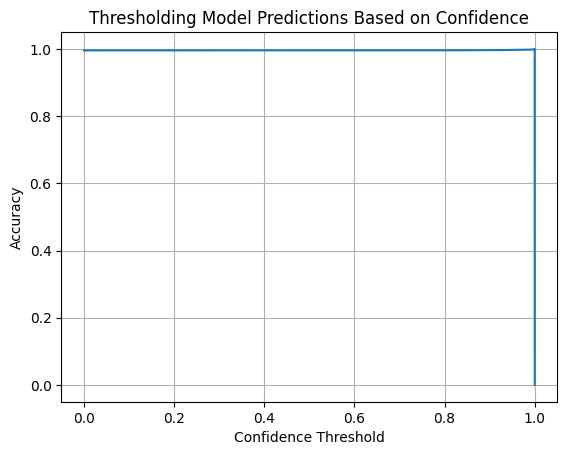

In [25]:
plot_confidence_threshold(argmax_probs, predictions, true_labels)

# # Test Stat

In [26]:
true_labels, predictions, argmax_probs = evaluate_model_with_argmax_probs(model, test_loader, device=device)

Evaluating: 100%|██████████| 938/938 [00:29<00:00, 31.63it/s]


In [27]:
equal_count, unequal_count, accuracy = compute_metrics(predictions, true_labels)

print(f"Number of Equal Samples: {equal_count}")
print(f"Number of Unequal Samples: {unequal_count}")
print(f"Accuracy: {accuracy:.4f}")

Number of Equal Samples: 14939
Number of Unequal Samples: 67
Accuracy: 0.9955


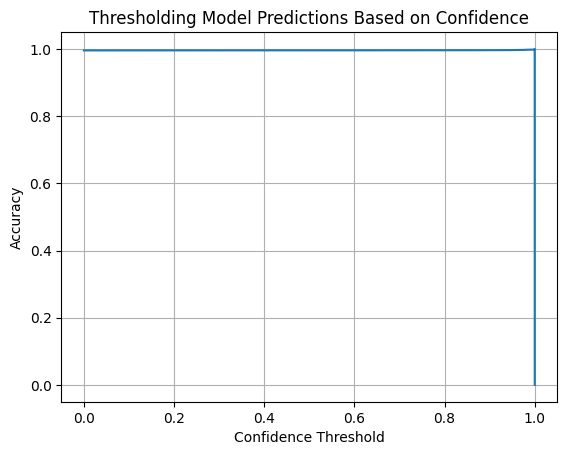

In [28]:
plot_confidence_threshold(argmax_probs, predictions, true_labels)